# **Importing Essential Libraries**

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [232]:
sales=pd.read_excel(r'/content/Fact_Sales.xlsx')
customers=pd.read_excel(r'/content/Dim_Customer.xlsx')
category=pd.read_excel(r"/content/Dim_Category.xlsx")
country=pd.read_excel(r"/content/Dim_Country1.xlsx")
date=pd.read_excel(r"/content/Dim_Date.xlsx")
location=pd.read_excel(r"/content/Dim_Location.xlsx")
product=pd.read_excel(r"/content/Dim_Product.xlsx")
subcategory=pd.read_excel(r"/content/Dim_SubCategory.xlsx")

In [233]:
# Merge fact and dimension tables
df = sales.merge(customers, on="CustomerID", how="left") \
               .merge(product, on="ProductID", how="left") \
               .merge(subcategory, on="SubCategoryID", how="left") \
               .merge(category, on="CategoryID", how="left") \
               .merge(location, on="LocationID", how="left") \
               .merge(country, on="CountryID", how="left")

df.head()

,InvoiceNo,InvoiceDate,CustomerID,ProductID,Quantity,UnitPrice,TotalAmount,Name,Gender,Age,...,Price,Cost,SubCategoryName,CategoryID,CategoryName,City,State,CountryID,Country,Region
0,INV0000001,2024-10-29,C1702,P023,5,671.66,3358.30,Fatma Ali,Female,56,...,671.66,495.79,Washing Machines,C02,Home Appliances,Riyadh,Riyadh,CT02,Saudi Arabia,Middle East
1,INV0000002,2025-01-16,C0338,P040,3,621.13,1863.39,Omar Khaled,Male,42,...,621.13,426.48,Washing Machines,C02,Home Appliances,Giza,Giza,CT01,Egypt,Middle East
2,INV0000003,2025-05-15,C0462,P077,5,825.61,4128.05,Robert Wilson,Male,53,...,825.61,655.62,Mobile Phones,C01,Electronics,Los Angeles,California,CT03,USA,North America
3,INV0000004,2025-05-01,C1750,P011,1,49.79,49.79,Mostafa Ali,Male,46,...,49.79,27.75,Fiction,C04,Books,Jeddah,Makkah,CT02,Saudi Arabia,Middle East
4,INV0000005,2025-07-16,C0427,P010,2,465.52,931.04,Ahmed Hassan,Male,51,...,465.52,406.45,Refrigerators,C02,Home Appliances,Dammam,Eastern,CT02,Saudi Arabia,Middle East


In [234]:
# Calculate IQR
Q1 = df["TotalAmount"].quantile(0.25)
Q3 = df["TotalAmount"].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
data= df[(df["TotalAmount"] >= lower_bound) & (df["TotalAmount"] <= upper_bound)]

print("Original data size:", len(df))
print("After removing outliers:", len(data))

Original data size: 49500
After removing outliers: 47002


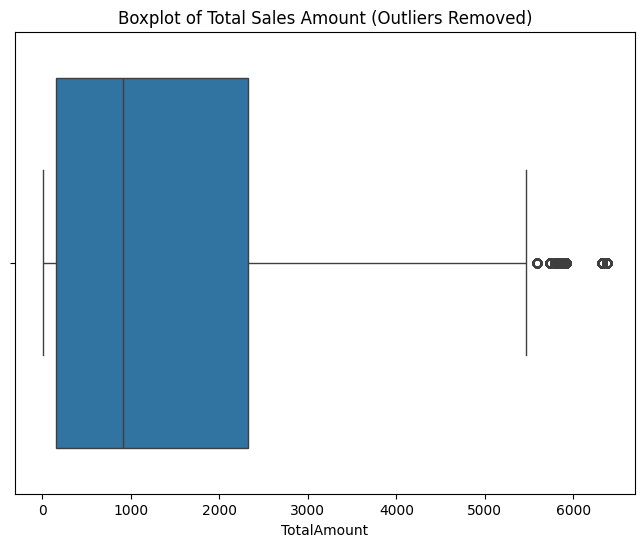

In [235]:
plt.figure(figsize=(8,6))
sns.boxplot(x=data["TotalAmount"])
plt.title("Boxplot of Total Sales Amount (Outliers Removed)")
plt.show()


In [236]:
# Drop identifiers and dates
drop_cols = ["InvoiceNo", "InvoiceDate", "CustomerID", "ProductID",
             "SubCategoryID", "CategoryID", "LocationID", "CountryID", "RegistrationDate", "Name"]

data = df.drop(columns=drop_cols, errors="ignore")

# Show selected features
data.head()


,Quantity,UnitPrice,TotalAmount,Gender,Age,ProductName,Price,Cost,SubCategoryName,CategoryName,City,State,Country,Region
0,5,671.66,3358.30,Female,56,Bosch Serie 6,671.66,495.79,Washing Machines,Home Appliances,Riyadh,Riyadh,Saudi Arabia,Middle East
1,3,621.13,1863.39,Male,42,LG Washing Machine,621.13,426.48,Washing Machines,Home Appliances,Giza,Giza,Egypt,Middle East
2,5,825.61,4128.05,Male,53,iPhone 14,825.61,655.62,Mobile Phones,Electronics,Los Angeles,California,USA,North America
3,1,49.79,49.79,Male,46,Game of Thrones,49.79,27.75,Fiction,Books,Jeddah,Makkah,Saudi Arabia,Middle East
4,2,465.52,931.04,Male,51,LG Double Door,465.52,406.45,Refrigerators,Home Appliances,Dammam,Eastern,Saudi Arabia,Middle East


In [237]:
# Encode categorical variables
cat_cols = data.select_dtypes(include=["object"]).columns
le = LabelEncoder()

for col in cat_cols:
    data[col] = le.fit_transform(data[col].astype(str))

data.head()

,Quantity,UnitPrice,TotalAmount,Gender,Age,ProductName,Price,Cost,SubCategoryName,CategoryName,City,State,Country,Region
0,5,671.66,3358.30,0,56,2,671.66,495.79,7,3,11,11,2,1
1,3,621.13,1863.39,1,42,8,621.13,426.48,7,3,5,6,0,1
2,5,825.61,4128.05,1,53,30,825.61,655.62,3,2,8,4,3,2
3,1,49.79,49.79,1,46,5,49.79,27.75,0,0,7,9,2,1
4,2,465.52,931.04,1,51,6,465.52,406.45,5,3,4,5,2,1


In [238]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

data_scaled.head()

,Quantity,UnitPrice,TotalAmount,Gender,Age,ProductName,Price,Cost,SubCategoryName,CategoryName,City,State,Country,Region
0,1.413836,0.103505,0.704012,-1.019338,0.832728,-1.386112,0.103505,0.146843,1.001189,1.097605,1.590032,1.559396,0.416129,-0.019964
1,-0.001015,0.019271,0.015442,0.981028,-0.110256,-0.670054,0.019271,-0.008837,1.001189,1.097605,-0.152671,0.112463,-1.379173,-0.019964
2,1.413836,0.360139,1.058567,0.981028,0.630660,1.955491,0.360139,0.505846,-0.565766,0.226532,0.718680,-0.466310,1.313781,1.393761
3,-1.415865,-0.933152,-0.819920,0.981028,0.159168,-1.028083,-0.933152,-0.904447,-1.740982,-1.515615,0.428230,0.980623,0.416129,-0.019964
4,-0.708440,-0.240131,-0.414008,0.981028,0.495948,-0.908740,-0.240131,-0.053828,0.217712,1.097605,-0.443122,-0.176923,0.416129,-0.019964


## **Elbow Method (to determine the optimal num of clusters)**

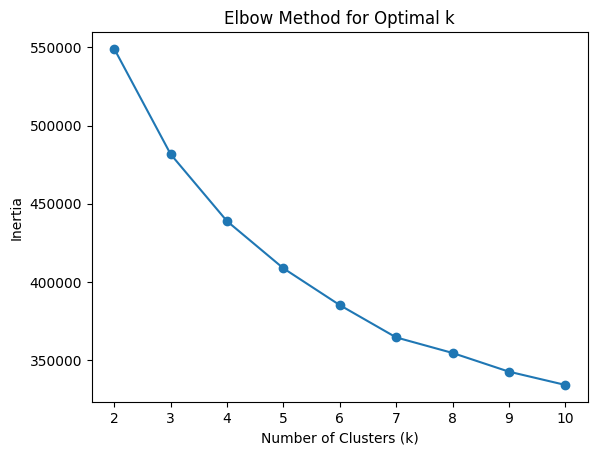

In [239]:
inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

## Load & Merge Data

In [240]:
# Load Excel files
fact_sales = pd.read_excel("Fact_Sales.xlsx")
dim_customer = pd.read_excel("Dim_Customer.xlsx")
dim_product = pd.read_excel("Dim_Product.xlsx")
dim_subcategory = pd.read_excel("Dim_SubCategory.xlsx")
dim_category = pd.read_excel("Dim_Category.xlsx")
dim_location = pd.read_excel("Dim_Location.xlsx")
dim_country = pd.read_excel("Dim_Country1.xlsx")

# Merge fact & dimensions into one dataset
data = fact_sales.merge(dim_customer, on="CustomerID", how="left") \
               .merge(dim_product, on="ProductID", how="left") \
               .merge(dim_subcategory, on="SubCategoryID", how="left") \
               .merge(dim_category, on="CategoryID", how="left") \
               .merge(dim_location, on="LocationID", how="left") \
               .merge(dim_country, on="CountryID", how="left")

data.head()


,InvoiceNo,InvoiceDate,CustomerID,ProductID,Quantity,UnitPrice,TotalAmount,Name,Gender,Age,...,Price,Cost,SubCategoryName,CategoryID,CategoryName,City,State,CountryID,Country,Region
0,INV0000001,2024-10-29,C1702,P023,5,671.66,3358.30,Fatma Ali,Female,56,...,671.66,495.79,Washing Machines,C02,Home Appliances,Riyadh,Riyadh,CT02,Saudi Arabia,Middle East
1,INV0000002,2025-01-16,C0338,P040,3,621.13,1863.39,Omar Khaled,Male,42,...,621.13,426.48,Washing Machines,C02,Home Appliances,Giza,Giza,CT01,Egypt,Middle East
2,INV0000003,2025-05-15,C0462,P077,5,825.61,4128.05,Robert Wilson,Male,53,...,825.61,655.62,Mobile Phones,C01,Electronics,Los Angeles,California,CT03,USA,North America
3,INV0000004,2025-05-01,C1750,P011,1,49.79,49.79,Mostafa Ali,Male,46,...,49.79,27.75,Fiction,C04,Books,Jeddah,Makkah,CT02,Saudi Arabia,Middle East
4,INV0000005,2025-07-16,C0427,P010,2,465.52,931.04,Ahmed Hassan,Male,51,...,465.52,406.45,Refrigerators,C02,Home Appliances,Dammam,Eastern,CT02,Saudi Arabia,Middle East


In [241]:
from sklearn.metrics import silhouette_score

for k in range(2,6):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(customer_scaled)
    score = silhouette_score(customer_scaled, labels)
    print(f"k={k}, Silhouette Score={score:.3f}")


k=2, Silhouette Score=0.321
k=3, Silhouette Score=0.250
k=4, Silhouette Score=0.274
k=5, Silhouette Score=0.260


## Customers Clustering

In [242]:
customer_df = data.groupby("CustomerID").agg({
    "TotalAmount": "sum",   # Total spending
    "Quantity": "sum",      # Total quantity bought
    "InvoiceNo": "nunique", # Frequency (# of invoices)
    "Age": "mean"           # Average age
}).reset_index()

customer_df.rename(columns={
    "TotalAmount": "Total Sales",
    "Quantity": "TotalQuantity",
    "InvoiceNo": "Frequency",
    "Age": "AvgAge"
}, inplace=True)

customer_df.head()


,CustomerID,Total Sales,TotalQuantity,Frequency,AvgAge
0,C0001,36712.88,60,19,67.0
1,C0002,51275.27,91,32,53.0
2,C0003,30716.81,57,17,44.0
3,C0004,57565.44,77,27,29.0
4,C0005,45177.30,90,29,34.0


In [243]:
scaler = StandardScaler()
customer_scaled = pd.DataFrame(scaler.fit_transform(customer_df.drop(columns=["CustomerID"])),
                               columns=customer_df.drop(columns=["CustomerID"]).columns) # Update columns to include encoded gender

## Elbow Method (to determine the optimal num of clusters)

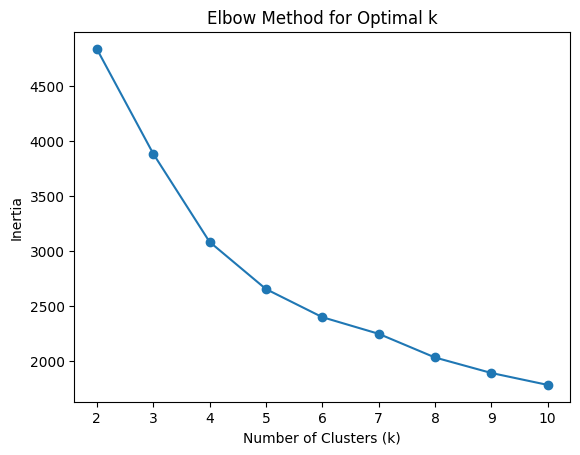

In [244]:
inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [245]:
kmeans_customers = KMeans(n_clusters=2, random_state=42)
customer_df["Cluster"] = kmeans_customers.fit_predict(customer_scaled)

customer_df["Cluster"].value_counts()


,count
Cluster,
1,1007
0,993


In [246]:
# Compute means
profile = customer_df.groupby("Cluster")[["Total Sales", "TotalQuantity", "Frequency", "AvgAge"]].mean()

# Sort clusters by Total Sales
cluster_order = profile["Total Sales"].sort_values().index.tolist()

# Map IDs → business-friendly names
cluster_map = {
    cluster_order[0]: "Low-Value Customers",
    cluster_order[1]: "Loyal Big Spenders"
}

customer_df["Segment"] = customer_df["Cluster"].map(cluster_map)

# Drop old numeric cluster column if you want only names
customer_df.drop(columns=["Cluster"])

# Show counts
print(customer_df["Segment"].value_counts())

Segment
Low-Value Customers    1007
Loyal Big Spenders      993
Name: count, dtype: int64


In [247]:
customer_summary = customer_df.groupby("Segment").agg({
    "Total Sales": "mean",
    "TotalQuantity": "mean",
    "Frequency": "mean",
    "AvgAge": "mean",
    "CustomerID": "count"
}).rename(columns={"CustomerID": "Number of Customers"}).round(2)

customer_summary


,Total Sales,TotalQuantity,Frequency,AvgAge,Number of Customers
Segment,,,,,
Low-Value Customers,35863.73,61.88,21.16,43.28,1007
Loyal Big Spenders,54847.46,86.87,28.39,43.99,993


In [248]:
# Compute cluster means for customers
customer_profile = customer_df.groupby("Cluster")[["Total Sales", "TotalQuantity", "Frequency", "AvgAge"]].mean()

# Sort clusters by Total Sales (spending)
cluster_order = customer_profile["Total Sales"].sort_values().index.tolist()

# Map cluster IDs to business-friendly names
# (works for 2 clusters: Low-Value vs Loyal Big Spenders)
cluster_map = {
    cluster_order[0]: "Low-Value Customers",
    cluster_order[1]: "Loyal Big Spenders"
}

# Replace Cluster numbers with segment names
customer_df["Segment"] = customer_df["Cluster"].map(cluster_map)

# Drop old numeric Cluster column if you want only names
customer_df.drop(columns=["Cluster"], inplace=True)

# Show results
customer_df[["CustomerID", "Total Sales", "Frequency", "TotalQuantity", "AvgAge", "Segment"]].head(20)


,CustomerID,Total Sales,Frequency,TotalQuantity,AvgAge,Segment
0,C0001,36712.88,19,60,67.0,Low-Value Customers
1,C0002,51275.27,32,91,53.0,Loyal Big Spenders
2,C0003,30716.81,17,57,44.0,Low-Value Customers
3,C0004,57565.44,27,77,29.0,Loyal Big Spenders
4,C0005,45177.30,29,90,34.0,Loyal Big Spenders
5,C0006,47734.33,22,78,25.0,Low-Value Customers
6,C0007,58927.57,21,63,61.0,Low-Value Customers
7,C0008,23319.00,14,43,65.0,Low-Value Customers
8,C0009,30306.32,20,64,37.0,Low-Value Customers
9,C0010,54130.80,25,69,58.0,Loyal Big Spenders


## **Product** **Clustering**

In [249]:
# Step 1: Aggregate product-level data
product_df = data.groupby("ProductID").agg({
    "TotalAmount": "sum",   # total revenue
    "Quantity": "sum",      # total quantity sold
    "Price": "mean",        # avg price
    "Cost": "mean"          # avg cost
}).reset_index()

# Rename column for consistency
product_df.rename(columns={"TotalAmount": "Total Sales"}, inplace=True)

# Add Profit Margin
product_df["ProfitMargin"] = product_df["Price"] - product_df["Cost"]

product_df.head()


,ProductID,Total Sales,Quantity,Price,Cost,ProfitMargin
0,P001,1432625.88,1869,766.52,571.47,195.05
1,P002,3902369.28,1772,2202.24,1903.96,298.28
2,P003,120248.34,1878,64.03,51.06,12.97
3,P004,878255.26,1681,522.46,449.14,73.32
4,P005,19075.68,2038,9.36,7.83,1.53


In [250]:
# Step 2: Scale product features
scaler = StandardScaler()
product_scaled = scaler.fit_transform(product_df.drop(columns=["ProductID"]))

## Elbow Method (to determine the optimal num of clusters)

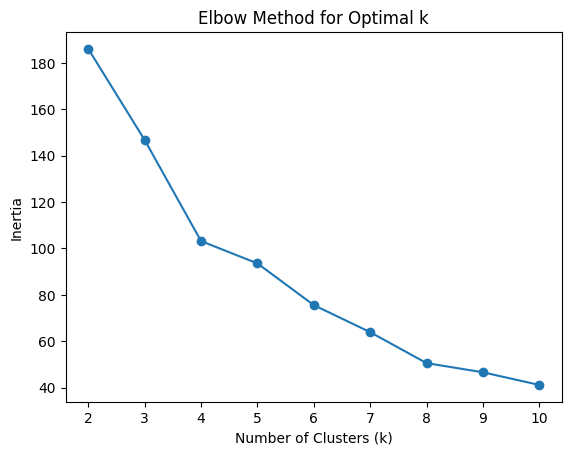

In [251]:
inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(product_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [252]:
# Step 3: Apply KMeans (2 clusters)
kmeans_products = KMeans(n_clusters=2, random_state=42)
product_df["Cluster"] = kmeans_products.fit_predict(product_scaled)

In [253]:

# Step 4: Compute cluster means
product_profile = product_df.groupby("Cluster")[["Total Sales", "Quantity", "Price", "Cost", "ProfitMargin"]].mean()

# Step 5: Sort clusters by Price (to separate mass-market vs premium)
cluster_order = product_profile["Price"].sort_values().index.tolist()


In [254]:
# Step 6: Map cluster IDs to names
product_map = {
    cluster_order[0]: "Mass-Market Products",
    cluster_order[1]: "Premium Products"
}

# Step 7: Replace cluster numbers with names
product_df["Cluster"] = product_df["Cluster"].map(product_map)

# Step 8: Show results
product_df["Cluster"].value_counts()


,count
Cluster,
Mass-Market Products,56
Premium Products,24


In [255]:
# Summary table for products
product_summary = product_df.groupby("Cluster").agg({
    "Total Sales": "mean",
    "Quantity": "mean",
    "Price": "mean",
    "Cost": "mean",
    "ProfitMargin": "mean",
    "ProductID": "count"
}).rename(columns={"ProductID": "Number of Products"})

product_summary = product_summary.round(2)
product_summary


,Total Sales,Quantity,Price,Cost,ProfitMargin,Number of Products
Cluster,,,,,,
Mass-Market Products,510953.75,1853.64,276.01,196.54,79.47,56
Premium Products,2581870.90,1865.29,1382.98,975.93,407.05,24


In [256]:
# Compute cluster means for products
product_profile = product_df.groupby("Cluster")[["Total Sales", "Quantity", "Price", "Cost", "ProfitMargin"]].mean()

# Sort clusters by Price
cluster_order = product_profile["Price"].sort_values().index.tolist()

# Map cluster IDs to business-friendly names
product_map = {
    cluster_order[0]: "Mass-Market Products",
    cluster_order[1]: "Premium Products"
}

# Replace Cluster numbers with segment names
product_df["Segment"] = product_df["Cluster"].map(product_map)

# Drop old numeric Cluster column if you want only names
product_df.drop(columns=["Cluster"], inplace=True)

# Show results
product_df[["ProductID", "Total Sales", "Quantity", "Price", "ProfitMargin", "Segment"]].head(20)


,ProductID,Total Sales,Quantity,Price,ProfitMargin,Segment
0,P001,1432625.88,1869,766.52,195.05,Mass-Market Products
1,P002,3902369.28,1772,2202.24,298.28,Premium Products
2,P003,120248.34,1878,64.03,12.97,Mass-Market Products
3,P004,878255.26,1681,522.46,73.32,Mass-Market Products
4,P005,19075.68,2038,9.36,1.53,Mass-Market Products
5,P006,1958563.54,1751,1118.54,227.45,Premium Products
6,P007,2229774.40,1904,1171.10,500.24,Premium Products
7,P008,759133.98,1881,403.58,69.67,Mass-Market Products
8,P009,1262414.93,1907,661.99,208.91,Mass-Market Products
9,P010,886350.08,1904,465.52,59.07,Mass-Market Products


In [257]:
from sklearn.metrics import silhouette_score

sil_customer = silhouette_score(customer_scaled, kmeans_customers.labels_)
sil_product = silhouette_score(product_scaled, kmeans_products.labels_)

print("Customer Clustering Silhouette Score:", sil_customer)
print("Product Clustering Silhouette Score:", sil_product)


Customer Clustering Silhouette Score: 0.32069128649218204
Product Clustering Silhouette Score: 0.4770136058346564
